# Spin lattice models

In this tutorial we want to show you how to use [struqture](https://hqsquantumsimulations.github.io/struqture/) to construct a spin lattice model and interface directly with the solver backend to obtain the associated NMR spectrum. Since this is not the primary use case for the `hqs_nmr` package, not all features that exist for molecules are supported, so we have to do a bit more work to get a spectrum.

Let us start as usual by importing the necessary modules.

In [1]:
# HQS modules
from hqs_nmr.solver.solver import NMR_FREQUENCY_SOLVERS
from hqs_nmr import NMRCalculationParameters

from struqture_py.spins import PauliHamiltonian, PauliProduct

# external modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import toeplitz

# Can be installed via HQStage and gives the plots a nice layout. This is an optional dependency.
import HQStyle
HQStyle.import_all()

Next we need to create the system description. As an example we are going to take a simple spin chain with nearest neighbor interaction and periodic boundary conditions.

In [2]:
number_spins = 12
shifts = np.ones(number_spins)

J_coupling = np.zeros(number_spins)
J_coupling[1] = J_coupling[-1] = -0.1
J_coupling = toeplitz(J_coupling)

print(shifts)
print(J_coupling)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1]
 [-0.1  0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.1  0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.1  0.  -0.1  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.1  0.  -0.1  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.1  0.  -0.1  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.1  0.  -0.1  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.1  0.  -0.1  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.1  0.  -0.1  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.1  0.  -0.1  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1  0.  -0.1]
 [-0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1  0. ]]


Next we can turn this into a struqture spin hamiltonian as it will be needed by the NMR solver. Here it is important to actually define an NMR Hamiltonian of the general form

$
\begin{align}
	\hat{H} &= \sum_l \tilde{\delta}_l \hat{I}^z_l + \sum_{k < l} \tilde{J}_{kl} \, \mathbf{\hat I}_k \cdot \mathbf{\hat I}_l
\end{align}
$

This is the only Hamiltonian the solvers are currently designed for. To keep the formula condensed, we have combined some prefactors and terms into $\tilde{\delta}$ and $\tilde{J}$, respectively. For more information on their exact form check out the [NMR](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/background/nmr.html) section in the documentation.

In [3]:
hamiltonian = PauliHamiltonian()
for i in range(number_spins):
    sigma_z = PauliProduct().set_pauli(i, "Z")
    hamiltonian.add_operator_product(sigma_z, 0.5 * shifts[i])
    for j in range(i, number_spins):
        prod_xx = PauliProduct().set_pauli(i, "X").set_pauli(j, "X")
        prod_yy = PauliProduct().set_pauli(i, "Y").set_pauli(j, "Y")
        prod_zz = PauliProduct().set_pauli(i, "Z").set_pauli(j, "Z")
        hamiltonian.add_operator_product(prod_xx, 0.5 * np.pi * J_coupling[i, j])
        hamiltonian.add_operator_product(prod_yy, 0.5 * np.pi * J_coupling[i, j])
        hamiltonian.add_operator_product(prod_zz, 0.5 * np.pi * J_coupling[i, j])

Next we need to choose a solver:

In [4]:
for key in NMR_FREQUENCY_SOLVERS.keys():
    print(key)

nmr_solver
nmr_solver_local_su2
reference_nmr_solver
complete_nmr_solver


The four available solvers are:

- `nmr_solver`: Exploits $I^z$ conservation, but does not take care of local SU(2) symmetry
- `nmr_solver_local_su2`: Takes into account also the local SU(2) symmetry.
- `reference_solver`: Takes no symmetries into account.
- `complete_nmr_solver`: Evaluates the time dependent expectation value without an approximation for the initial density matrix. No symmetries are taken into account.

Let's choose for now the `nmr_solver` as it evaluates the spectrum exactly, and should still be fast for a 12-site spin model.

In [5]:
solver = NMR_FREQUENCY_SOLVERS["nmr_solver"]

To run the calculation, we need to define some extra parameters. For the gyromagnetic ratios, let's assume all the spins in the system are the same and let's further assume that we want to normalize the spectrum later anyway. In this case we can set them all to one.

In [6]:
gyromagnetic_ratios = np.ones(hamiltonian.current_number_spins())

Next we have to guess a frequency range. For this, we will simply take the sum of the absolute values of the shifts. With this we should overshoot the upper and lower bounds of the spectrum, but for this simple example it will be sufficient. Additionally, we will choose a linear discretization for the frequencies. 

In [7]:
shift_sum = np.sum(np.abs(shifts))

number_omegas = 2000
omegas = np.linspace(-shift_sum, shift_sum, number_omegas)

Also we need to define an artificial broadening $\eta$. We can estimate a first guess for it via the *J*-coupling. Note that we are defining it as a vector. This is because in a molecule it can be useful to use different broadenings for different spins. Since we are dealing with a periodic lattice model, we will choose the broadening to be the same for all spins.

In [8]:
eta = 2 * np.pi * np.max(abs(J_coupling)) / 10 * np.ones(hamiltonian.current_number_spins())

We also have to define for which spin contributions to evaluate the spectrum. Let's choose all for the sake of simplicity.

In [9]:
spin_contributions = list(range(number_spins))

The rest of the calculation parameters can be defined simply via the default settings of the `NMRCaclulationParameters` data type. Note that the constructor of the class requires a magnetic field as input, as the typical user would be interested in an NMR experiment. The value of magnetic field is not used within the solvers though, so we can just put it to zero.

In [10]:
calculation_parameters = NMRCalculationParameters(field_T=0.0)

Now, we evaluate the spectrum:

In [11]:
spin_contributions = solver(
    hamiltonian,
    normalized_gyromagnetic_ratios=gyromagnetic_ratios,
    omegas=omegas,
    eta=eta,
    spin_contribution_indices=spin_contributions,
    calculation_parameters=calculation_parameters,
)

Finally, we can plot the spectral function:

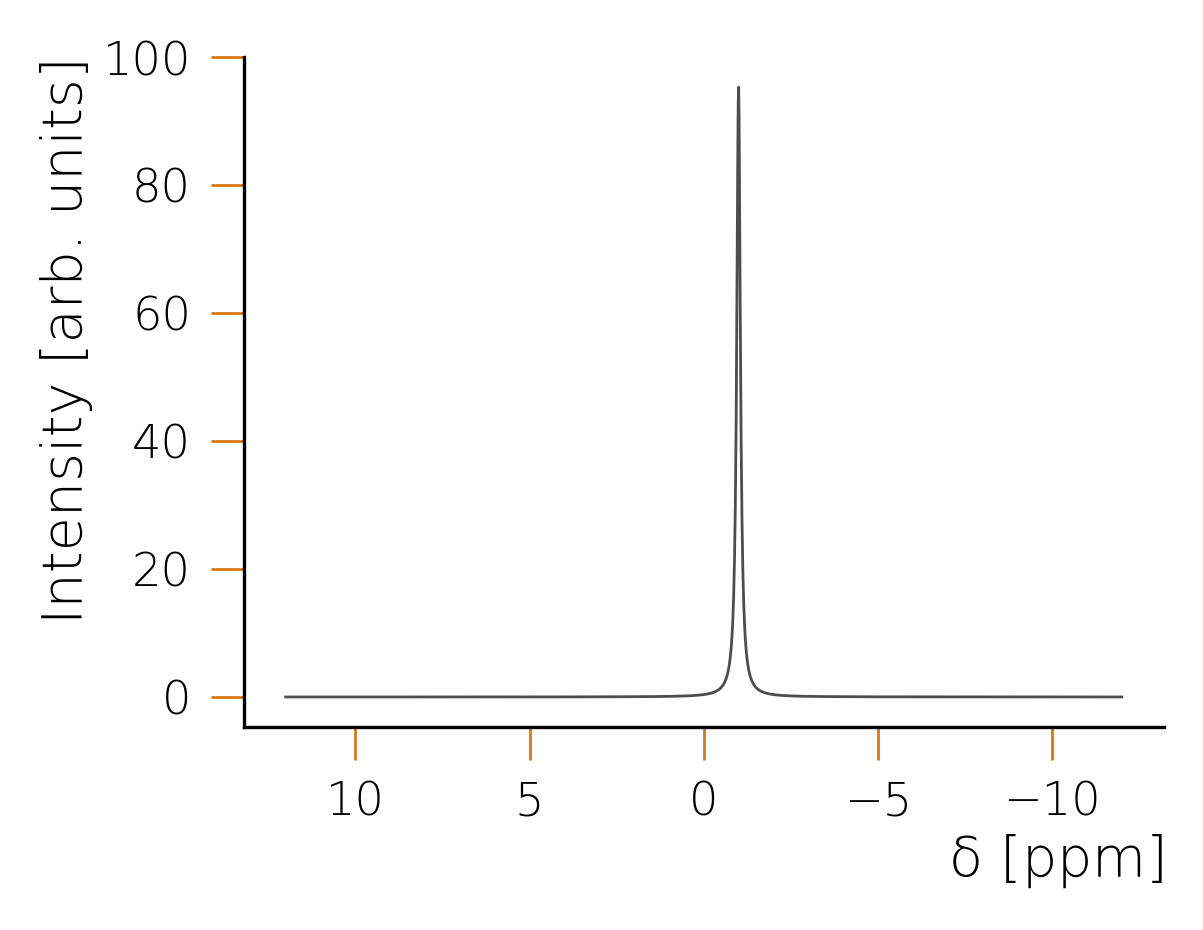

In [12]:
plt.plot(omegas, np.sum(spin_contributions, axis=0), linewidth=0.5)
plt.gca().invert_xaxis()
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.show()

If you want to play around with this example, we suggest to increase the system size and check how the runtime increases. Then switch to the `nmr_solver_local_su2` and check for which system sizes the runtime improves and what system sizes you can still calculate. For more information on this solver check out [tutorial 6](6_high_symmetry_molecules.ipynb). There we tackle a molecule with 22 spins, without using any approximations.